\setcounter{secnumdepth}{0}

# Assignment 1 - Simulating dynamical systems in Jax

    Name: Clara Periago
    Student #: s1067476

In [4]:
# The assignment uses the following imports, try to avoid importing other libraries
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.random import PRNGKey

# For plotting, you may use any plotting library you prefer, the graphs from the lecture notes are predominately made with [matplotlib](https://matplotlib.org/). If you have not used it before, you will likely have to install it via your preferred package manager first.
import matplotlib.pyplot as plt

# Exercise 1: Introduction to Jax

In this assignment, we will learn how to use the Jax framework for automatic differentiation (for install see https://jax.readthedocs.io/en/latest/installation.html). Throughout the course, JAX will be used to simulate dynamical systems and learn these from observations with a neural network. 

While much of the jax API is similar to NumPy, there are some important differences. We recommend to look at the following articles before starting the assignment:

- [Jax Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)
- [Training a simple NN with Jax](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/neural_network_with_tfds_data.ipynb)
- [Jax vs. NumPy](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html)

## Exercise 1.1

In JAX, random keys are used for random sampling. Generate 100 keys and use jax.vmap to sample from a normal distribution with each key. Verify they do not generate the same samples, but their statistics (mean, variance) are correct.

## Solution 1.1

In [88]:
mean = 0
std = 2

out_shape = (100_000,) # let's take 100_000 samples


keys = jnp.arange(100)

# max all key indices to a key obj
make_key = jax.vmap(PRNGKey)
# map key to normal samples
fn = jax.vmap(lambda k: mean + std * jr.normal(k, shape=out_shape), in_axes=0)

# actually generate the samples
samples = fn(make_key(keys))

print(f"Shape: {samples.shape}")

means = samples.mean(axis=1)
stds = samples.std(axis=1)

max_mean_diff = jnp.abs(means - mean).max()
max_std_diff = jnp.abs(stds - std).max()

# print error
print(f"Maximum difference in mean sample with actual mean: {max_mean_diff:.4f}")
print(f"Maximum difference in std sample with actual std: {max_std_diff:.4f}")

Shape: (100, 100000)
Maximum difference in mean sample with actual mean: 0.0213
Maximum difference in std sample with actual std: 0.0119


## Exercise 1.2
For-loops can still be used in JAX, but jax.lax.scan() gives big speed-ups, and might therefore be preferred for heavy computations. Use jax.lax.scan() to compute the first 10 elements that come after 0 and 1 in Fibonacci sequence:

\begin{align}
    f_0&= 0\\
    f_1&= 1\\
    f_n&=f_{n-2}+f_{n-1},\,\text{for} \,n>1
\end{align}

Resulting in the sequence: $x_n=\{1,2,3,5,8,13,21,34,55,89\}$ 

## Solution 1.2

In [ ]:
from functools import partial

array = jnp.arange(0, 10) # indices to loop over

# jax.lax.scan :: (c -> a -> (c, b)) -> c -> [a] -> (c, [b])

# so f1 should be (c -> a -> (c, b))
# c will be a tuple of the previous elems n-2 and n-1
def f1(c, a):
    n2, n1 = c
    
    return (n1, n1 + n2), n1 + n2

jax.lax.scan(f1, (0, 1), array)

((Array(55, dtype=int32, weak_type=True),
  Array(89, dtype=int32, weak_type=True)),
 Array([ 1,  2,  3,  5,  8, 13, 21, 34, 55, 89], dtype=int32, weak_type=True))

## Exercise 1.3
Derive analytically the derivate of the function $f(x)= x^3 - \cos(x)$, and visualize the derivative. Next, use jax.grad() to compute the gradients of the given function with automatic differentiation, and plot the result next to your analytical result.

## Solution 1.3

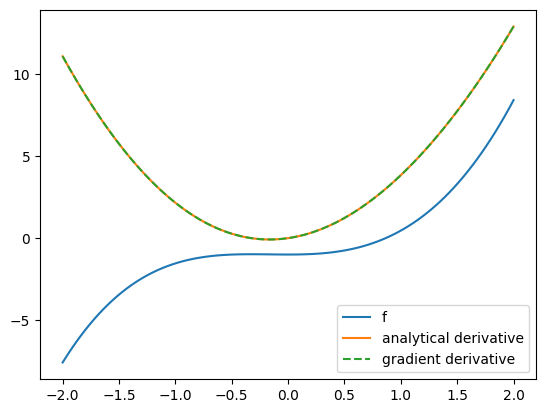

In [99]:
f = lambda x: x**3 - jnp.cos(x)

x = jnp.linspace(-2, 2, 100)

y = jax.vmap(f)(x)

#YOUR CODE HERE

df = lambda x: 3*x**2 + jnp.sin(x)

dy = jax.vmap(df)(x)

gdf = jax.grad(f)
gdy = jax.vmap(gdf)(x)

plt.plot(x, y, label="f")
plt.plot(x, dy, label="analytical derivative")
plt.plot(x, gdy, label="gradient derivative", linestyle="--")
plt.legend()
plt.show()

## Exercise 1.4
A major application of automatic differentiation is optimization. Next, we will use the Jax to optimize three parameters. 

- Define a loss function that takes the parameters and evaluation points as inputs, and returns the loss as an output.
- use jax.grad() to obtain the gradients of this function w.r.t. the parameters.
- Update the parameters by taking a gradient descent step with a small learning rate, and repeat this multiple times until convergence.

Visualize the optimized function, and compare this to the true function.

## Solution 1.4

In [111]:
import numpy as np

Final MSE: 0.0027609041426330805


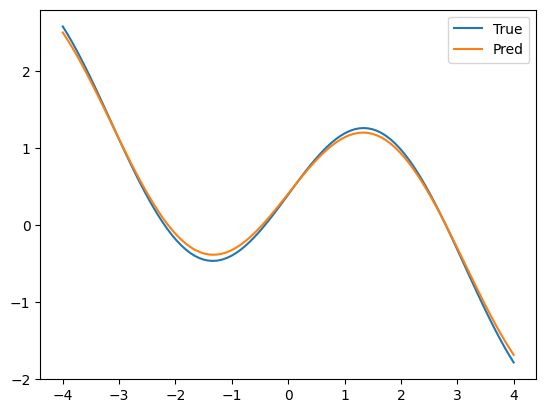

In [117]:
true_params = jnp.array([1.3, -0.3, 0.4])
true_f = lambda x: true_params[0]*jnp.sin(x) + true_params[1]*x + true_params[2]

x = jnp.linspace(-4, 4, 100)
y = jax.vmap(true_f)(x)

params = jnp.array([1.0,1.0,1.0])
estimate_f = lambda param, x: param[0]*jnp.sin(x) + param[1]*x + param[2]


### ---- ###

lr = 0.01
epochs = 200
verbose = 0

# simple mse
def mse(y_pred, y_true):
    return jnp.square(y_pred - y_true).mean()

# loss by passing in params and the index of the element
def loss(*params):
    val = estimate_f(params, x)
    return mse(val, y)

for i in range(epochs):
    gf = jax.grad(loss, argnums=(0, 1, 2)) # differentiate with respect to each param

    deltas = gf(*params)

    # using plain numpy here since jnp does not support tuples
    if verbose: print(f"Max loss {np.argmax(deltas)}: {np.max(deltas)}")

    # new value for the param is the current value
    # plus the loss times a learning rate
    # this could probably be vectorized too but for now we just have 3 params
    params = jnp.array([p - lr * d for d, p in zip(deltas, params)])

    if verbose: print(f"New params at epoch {i}: {params}")



pred_y = jax.vmap(estimate_f, in_axes=[None, 0])(params, x)

print(f"Final MSE: {mse(y, pred_y)}")

plt.plot(x, y, label='True')
plt.plot(x, pred_y, label='Pred')
plt.legend()
plt.show()


# Exercise 2: Conway's Game of Life

Simulate Conway's Game of Life in JAX. Try to make your solution as efficient as possible in terms of JAX functionality. One function that can be used for this is `jax.scipy.signal.convolve2d`, but this is not the only approach.

The rules on Conway's Game of Life:

Initialize a two-dimensional grid with cells that are on or off (alive of dead). At every time step, determine the next state of each cell with the following rules:

+ Any live cell with fewer than two live neighbours dies, as if by underpopulation.
+ Any live cell with two or three live neighbours lives on to the next generation.
+ Any live cell with more than three live neighbours dies, as if by overpopulation.
+ Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.

In [191]:
import time
from matplotlib import animation
from IPython.display import HTML


gridsize = 100
epochs = 150
n_gliders = 16


rkey = PRNGKey(42)
# uncomment for random board
# grid = jr.randint(rkey, (gridsize, gridsize), 0, 2, jnp.uint8)
grid = jnp.zeros(shape=(gridsize, gridsize), dtype=np.uint8)


kernel = jnp.array([[1, 1, 1], [1, 0, 1,], [1, 1, 1]], dtype=np.uint8)

glider = jnp.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)

h, w = glider.shape
# generate N random xy positions for each glider
positions = jr.randint(
    rkey, 
    (n_gliders, 2),
    0, 
    jnp.array([gridsize - h, gridsize - w])
)

# stamp a glider on the board
for k in range(n_gliders):
    i, j = positions[k]
    grid = grid.at[i : i + h, j : j + w].set(glider)

    

def iter(carry, a):
    conv = jax.scipy.signal.convolve2d(carry, kernel, mode="same")

    # when alive, keep being alive if within [2,3]
    alive = (carry == 1) & (conv > 1) & (conv < 4)
    # when dead, become alive if 3
    dead = (carry == 0) & (conv == 3)

    next = (alive | dead).astype(jnp.uint8)

    return next, next

# plotting
fig, ax = plt.subplots()

# initial state
im = ax.imshow(grid, interpolation='nearest')

start_time = time.time()
# update all states
_, states = jax.lax.scan(iter, grid, None, length=epochs)
print((states).shape)
print(f"Done in {time.time() - start_time:.2f} s")

def update(frame):
    im.set_array(states[frame])
    ax.set_title(f"Epoch {frame}")
    return [im]

ani = animation.FuncAnimation(
    fig, update, frames=epochs, interval=200, blit=True,
)
plt.close(fig)
HTML(ani.to_jshtml())

(150, 100, 100)
Done in 0.18 s
